In [1]:
# !nvidia-smi

In [2]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 596, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 596 (delta 128), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (596/596), 195.77 KiB | 6.31 MiB/s, done.
Resolving deltas: 100% (302/302), done.
Installing RAPIDS remaining 25.04 libraries
Using Python 3.11.13 environment at: /usr
Resolved 173 packages in 3.21s
 Downloaded cuproj-cu12
 Downloaded shapely
 Downloaded rmm-cu12
 Downloaded cudf-cu12
 Downloaded libkvikio-cu12
 Downloaded datashader
 Downloaded ucx-py-cu12
 Downloaded dask
 Downloaded cugraph-cu12
 Downloaded bokeh
 Downloaded librmm-cu12
 Downloaded cuspatial-cu12
 Downloaded cuml-cu12
 Downloaded pylibcugraph-cu12
 Downloaded cucim-cu12
 Downloaded libcuspatial-cu12
 Downloaded pylibcudf-cu12
 Downloaded libraft-cu12
 Downloaded raft-dask-cu12
 Downloaded libcuml-cu12
  × Failed to download `libcudf-cu12==25.4.0

In [3]:
import cudf
cudf.__version__

'25.02.01'

In [4]:
import cuml
cuml.__version__

'25.02.01'

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans as cpuKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from cuml.cluster import KMeans as gpuKMeans
import cudf
print("Import Selesai")

Import Selesai


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import pandas as pd
df = pd.read_csv('drive/MyDrive/ML/Dataset Kecil/Exasens.csv')

In [11]:
df.head()

,Diagnosis,ID,Imaginary Part,Unnamed: 3,Real Part,Unnamed: 5,Gender,Age,Smoking,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,Min,Avg.,Min,Avg.,NaN,NaN,NaN,NaN,NaN,Gender,Somking
2,COPD,301-4,-320.61,-300.5635307,-495.26,-464.1719907,1.0,77.0,2.0,NaN,NaN,Male=1,Non-smoker=1
3,COPD,302-3,-325.39,-314.7503595,-473.73,-469.2631404,0.0,72.0,2.0,NaN,NaN,Female=0,Ex-smoker=2
4,COPD,303-3,-323,-317.4360556,-476.12,-471.8976667,1.0,73.0,3.0,NaN,NaN,NaN,Active-smoker=3


In [12]:
df.isnull().sum()

,0
Diagnosis,2
ID,2
Imaginary Part,300
Unnamed: 3,300
Real Part,300
Unnamed: 5,300
Gender,2
Age,2
Smoking,2
Unnamed: 9,401


In [13]:
df_clean = df.dropna()

In [14]:
print(df_clean)

Empty DataFrame
Columns: [Diagnosis, ID, Imaginary Part, Unnamed: 3, Real Part, Unnamed: 5, Gender, Age, Smoking, Unnamed: 9, Unnamed: 10, Unnamed: 11, Unnamed: 12]
Index: []


In [15]:
df.head()

,Diagnosis,ID,Imaginary Part,Unnamed: 3,Real Part,Unnamed: 5,Gender,Age,Smoking,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,Min,Avg.,Min,Avg.,NaN,NaN,NaN,NaN,NaN,Gender,Somking
2,COPD,301-4,-320.61,-300.5635307,-495.26,-464.1719907,1.0,77.0,2.0,NaN,NaN,Male=1,Non-smoker=1
3,COPD,302-3,-325.39,-314.7503595,-473.73,-469.2631404,0.0,72.0,2.0,NaN,NaN,Female=0,Ex-smoker=2
4,COPD,303-3,-323,-317.4360556,-476.12,-471.8976667,1.0,73.0,3.0,NaN,NaN,NaN,Active-smoker=3


In [16]:
missing_percentage = df.isnull().sum() / len(df) * 100
print("Percentage of missing values per column:")
print(missing_percentage)

# Identify columns with high missing percentages (e.g., > 50%)
high_missing_columns = missing_percentage[missing_percentage > 50].index.tolist()
print(f"\nColumns with more than 50% missing values: {high_missing_columns}")

# Identify columns that appear to be metadata based on head and missing values
metadata_columns = ['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12']
print(f"Columns identified as metadata: {metadata_columns}")

# Combine columns to drop
columns_to_drop = list(set(high_missing_columns + metadata_columns))
print(f"Columns to drop: {columns_to_drop}")

# Create a new DataFrame by dropping the identified columns
df_filtered = df.drop(columns=columns_to_drop)

display(df_filtered.head())

Percentage of missing values per column:
Diagnosis           0.498753
ID                  0.498753
Imaginary Part     74.812968
Unnamed: 3         74.812968
Real Part          74.812968
Unnamed: 5         74.812968
Gender              0.498753
Age                 0.498753
Smoking             0.498753
Unnamed: 9        100.000000
Unnamed: 10       100.000000
Unnamed: 11        99.251870
Unnamed: 12        99.002494
dtype: float64

Columns with more than 50% missing values: ['Imaginary Part', 'Unnamed: 3', 'Real Part', 'Unnamed: 5', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12']
Columns identified as metadata: ['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12']
Columns to drop: ['Real Part', 'Unnamed: 3', 'Unnamed: 12', 'Unnamed: 9', 'Unnamed: 10', 'Imaginary Part', 'Unnamed: 11', 'Unnamed: 5']


,Diagnosis,ID,Gender,Age,Smoking
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,COPD,301-4,1.0,77.0,2.0
3,COPD,302-3,0.0,72.0,2.0
4,COPD,303-3,1.0,73.0,3.0


In [17]:
print(df_filtered.info())
print("\nDistribution of numerical columns:")
print(df_filtered[['Age', 'Gender', 'Smoking']].describe())
print("\nDistribution of categorical columns:")
print(df_filtered['Diagnosis'].value_counts())
print(df_filtered['ID'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Diagnosis  399 non-null    object 
 1   ID         399 non-null    object 
 2   Gender     399 non-null    float64
 3   Age        399 non-null    float64
 4   Smoking    399 non-null    float64
dtypes: float64(3), object(2)
memory usage: 15.8+ KB
None

Distribution of numerical columns:
              Age      Gender     Smoking
count  399.000000  399.000000  399.000000
mean    48.736842    0.398496    1.726817
std     18.566962    0.490203    0.742167
min     17.000000    0.000000    1.000000
25%     31.000000    0.000000    1.000000
50%     49.000000    0.000000    2.000000
75%     64.000000    1.000000    2.000000
max     93.000000    1.000000    3.000000

Distribution of categorical columns:
Diagnosis
HC          160
Asthma       80
Infected     80
COPD         79
Name: count, dtype: int64
ID
I18

In [18]:
# Impute numerical columns with median
df_filtered['Age'] = df_filtered['Age'].fillna(df_filtered['Age'].median())
df_filtered['Gender'] = df_filtered['Gender'].fillna(df_filtered['Gender'].median())
df_filtered['Smoking'] = df_filtered['Smoking'].fillna(df_filtered['Smoking'].median())

# Impute categorical columns
# 'Diagnosis' with mode
df_filtered['Diagnosis'] = df_filtered['Diagnosis'].fillna(df_filtered['Diagnosis'].mode()[0])
# 'ID' with a placeholder
df_filtered['ID'] = df_filtered['ID'].fillna('Unknown')

# Verify that there are no more missing values
print("\nMissing values after imputation:")
print(df_filtered.isnull().sum())


Missing values after imputation:
Diagnosis    0
ID           0
Gender       0
Age          0
Smoking      0
dtype: int64


In [19]:
print("\nMissing values after handling:")
print(df_filtered.isnull().sum())


Missing values after handling:
Diagnosis    0
ID           0
Gender       0
Age          0
Smoking      0
dtype: int64


In [20]:
selected_columns = ["Age", "Gender"]
df_selected = df_filtered[selected_columns].copy()

In [21]:
df_selected['Gender'] = df_selected['Gender'].astype(int)
df_selected.head()

,Age,Gender
0,49.0,0
1,49.0,0
2,77.0,1
3,72.0,0
4,73.0,1


In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_selected)

In [23]:
print(df_selected.isnull().sum())

Age       0
Gender    0
dtype: int64


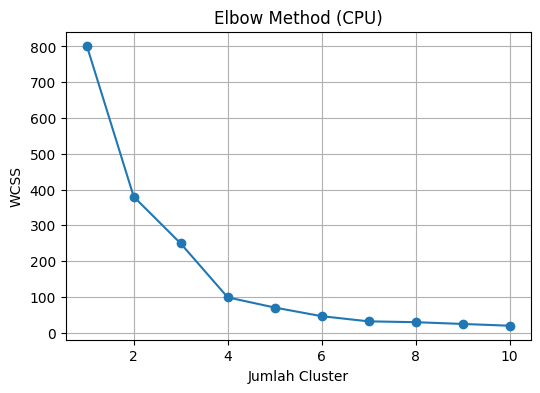

In [24]:
wcss = []
for i in range(1, 11):
    KMeans = cpuKMeans(n_clusters=i, random_state=42)
    KMeans.fit(X_scaled)
    wcss.append(KMeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method (CPU)")
plt.xlabel("Jumlah Cluster")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

In [25]:
start_cpu = time.time()
kmeans_cpu = cpuKMeans(n_clusters=4, random_state=42)
labels_cpu = kmeans_cpu.fit_predict(X_scaled)
cpu_time = time.time() - start_cpu

In [26]:
df_gpu = cudf.DataFrame.from_pandas(pd.DataFrame(X_scaled))
start_gpu = time.time()
kmeans_gpu = gpuKMeans(n_clusters=4, random_state=42)
labels_gpu = kmeans_gpu.fit_predict(df_gpu).to_numpy()
gpu_time = time.time() - start_gpu

/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


In [27]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_scaled)
df_vis = pd.DataFrame(reduced, columns=["PC1", "PC2"])
df_vis["CPU Cluster"] = labels_cpu
df_vis["GPU Cluster"] = labels_gpu


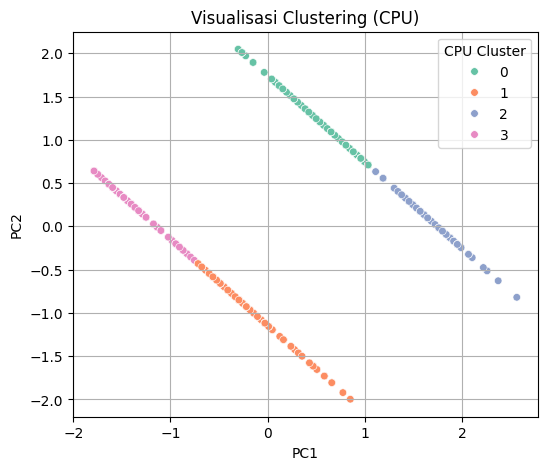

In [28]:
plt.figure(figsize=(6,5))
sns.scatterplot(data=df_vis, x="PC1", y="PC2", hue="CPU Cluster", palette="Set2", s=30)
plt.title("Visualisasi Clustering (CPU)")
plt.grid(True)
plt.show()


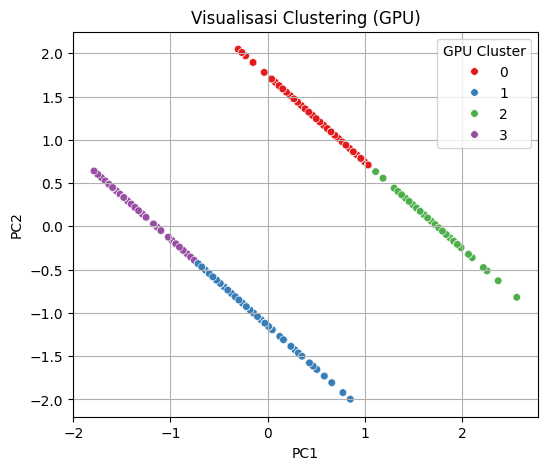

In [29]:
plt.figure(figsize=(6,5))
sns.scatterplot(data=df_vis, x="PC1", y="PC2", hue="GPU Cluster", palette="Set1", s=30)
plt.title("Visualisasi Clustering (GPU)")
plt.grid(True)
plt.show()


In [30]:
sil_cpu = silhouette_score(X_scaled, labels_cpu)
sil_gpu = silhouette_score(X_scaled, labels_gpu)

print(f"CPU - Waktu: {cpu_time:.2f}s | Silhouette Score: {sil_cpu:.3f}")
print(f"GPU - Waktu: {gpu_time:.2f}s | Silhouette Score: {sil_gpu:.3f}")


CPU - Waktu: 0.01s | Silhouette Score: 0.624
GPU - Waktu: 2.70s | Silhouette Score: 0.624


=======================================================================================================================================================================================================================================================================================

In [53]:
import pandas as pd
df = pd.read_csv('drive/MyDrive/ML/Dataset Kecil/buddymove_holidayiq.csv')

In [55]:
df.head()

,User Id,Sports,Religious,Nature,Theatre,Shopping,Picnic
0,User 1,2,77,79,69,68,95
1,User 2,2,62,76,76,69,68
2,User 3,2,50,97,87,50,75
3,User 4,2,68,77,95,76,61
4,User 5,2,98,54,59,95,86


In [56]:
df.isnull().sum()

,0
User Id,0
Sports,0
Religious,0
Nature,0
Theatre,0
Shopping,0
Picnic,0


In [63]:
selected_columns = ["Sports", "Religious", "Nature", "Shopping"]
df = df[selected_columns].dropna()
df_selected = df[selected_columns].dropna()


In [64]:
df.head()

,Sports,Religious,Nature,Shopping
0,2,77,79,68
1,2,62,76,69
2,2,50,97,50
3,2,68,77,76
4,2,98,54,95


In [65]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_selected)

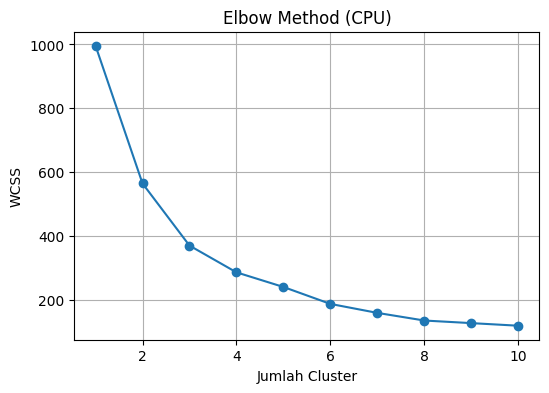

In [66]:
wcss = []
for i in range(1, 11):
    KMeans = cpuKMeans(n_clusters=i, random_state=42)
    KMeans.fit(X_scaled)
    wcss.append(KMeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method (CPU)")
plt.xlabel("Jumlah Cluster")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

In [89]:
start_cpu = time.time()
kmeans_cpu = cpuKMeans(n_clusters=4, random_state=42)
labels_cpu = kmeans_cpu.fit_predict(X_scaled)
cpu_time = time.time() - start_cpu

In [90]:
df_gpu = cudf.DataFrame.from_pandas(pd.DataFrame(X_scaled))
start_gpu = time.time()
kmeans_gpu = gpuKMeans(n_clusters=4, random_state=42)
labels_gpu = kmeans_gpu.fit_predict(df_gpu).to_numpy()
gpu_time = time.time() - start_gpu


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


In [92]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_scaled)
df_vis = pd.DataFrame(reduced, columns=["PC1", "PC2"])
df_vis["CPU Cluster"] = labels_cpu
df_vis["GPU Cluster"] = labels_gpu


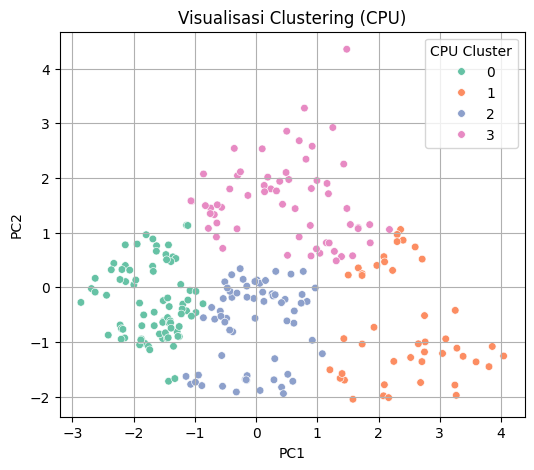

In [93]:
plt.figure(figsize=(6,5))
sns.scatterplot(data=df_vis, x="PC1", y="PC2", hue="CPU Cluster", palette="Set2", s=30)
plt.title("Visualisasi Clustering (CPU)")
plt.grid(True)
plt.show()


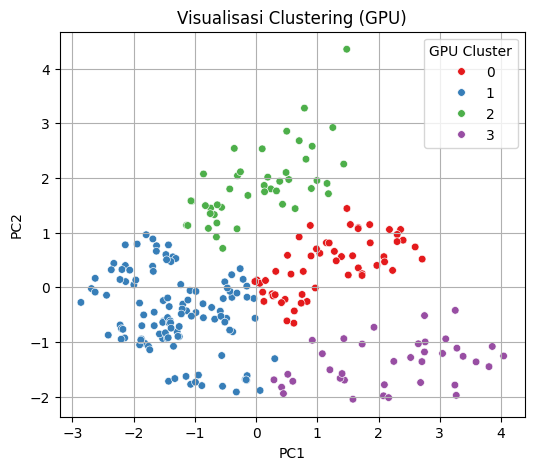

In [94]:
plt.figure(figsize=(6,5))
sns.scatterplot(data=df_vis, x="PC1", y="PC2", hue="GPU Cluster", palette="Set1", s=30)
plt.title("Visualisasi Clustering (GPU)")
plt.grid(True)
plt.show()


In [95]:
sil_cpu = silhouette_score(X_scaled, labels_cpu)
sil_gpu = silhouette_score(X_scaled, labels_gpu)

print(f"CPU - Waktu: {cpu_time:.2f}s | Silhouette Score: {sil_cpu:.3f}")
print(f"GPU - Waktu: {gpu_time:.2f}s | Silhouette Score: {sil_gpu:.3f}")


CPU - Waktu: 0.01s | Silhouette Score: 0.355
GPU - Waktu: 0.01s | Silhouette Score: 0.401
